In [ ]:
import ee
import geopandas as gpd
from shapely.geometry import mapping
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.enums import Resampling
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import geemap
import matplotlib.pyplot as plt

In [2]:
# -----------------------------------------------------------------------------
# 1. Initialize Google Earth Engine
# -----------------------------------------------------------------------------
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

In [4]:
# -----------------------------------------------------------------------------
# 2. Define the South Korea boundary
# -----------------------------------------------------------------------------

# use EE FeatureCollection
sk_fc = (
    ee.FeatureCollection('FAO/GAUL/2015/level0') \
    .filter(ee.Filter.eq('ADM0_NAME', 'Republic of Korea'))
    .first()
)
sk_geom = sk_fc.geometry().bounds()

In [5]:
# -----------------------------------------------------------------------------
# 3. Load GEDI Aboveground Biomass data (GEDI04_B) and filter by SK
# -----------------------------------------------------------------------------
gedi_fc = ee.Image('LARSE/GEDI/GEDI04_B_002') \
    .select('MU') \
    .clip(sk_geom)

In [6]:
# -----------------------------------------------------------------------------
# 4. Load Landsat 8 Surface Reflectance, filter by date & region, compute median
# -----------------------------------------------------------------------------
ls_col = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
          .filterBounds(sk_geom)
          .filterDate('2020-01-01', '2020-12-31')
          .map(lambda img: img.select(['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7']).divide(10000)))
#ls_median = ls_col.median().clip(sk_geom)

# explicitly select all 6 bands before exporting
bands = ['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7']
ls_median = ls_col.select(bands).median().clip(sk_geom)

In [8]:
# -----------------------------------------------------------------------------
# 5. Sample Landsat bands at GEDI points
# -----------------------------------------------------------------------------
training_fc = ls_median.addBands(gedi_fc.rename('agb')).sample(
    region=sk_geom,
    scale=1000,
    numPixels=5000,
    seed=42
).filter(ee.Filter.notNull(['SR_B2','agb']))

In [9]:
# -----------------------------------------------------------------------------
# 6. Export sample table to pandas
# -----------------------------------------------------------------------------
#    (since geemap.ee_to_pandas no longer exists)
feat_info = training_fc.getInfo()['features']
df = pd.DataFrame([f['properties'] for f in feat_info])
df = df.dropna()

In [10]:
# -----------------------------------------------------------------------------
# 7. Train/Test split
# -----------------------------------------------------------------------------
X = df[['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7']].values
y = df['agb'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [12]:
# -----------------------------------------------------------------------------
# 8. Train Random Forest Regressor
# -----------------------------------------------------------------------------
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
print(f"Test R^2 score: {rf.score(X_test, y_test):.3f}")

Test R^2 score: 0.453


In [ ]:
# -----------------------------------------------------------------------------
# 9. Estimate Biomass over South Korea
# -----------------------------------------------------------------------------

# Define a 30 × 30 km box around Jeonju (35.821° N, 127.148° E)
# Honam Plain around Jeonju is one of South Korea’s largest rice-growing regions
# Approx: 0.15° latitude (~16.7 km) and 0.17° longitude (~15 km) half-width
region = ee.Geometry.Rectangle([
    127.1480 - 0.17,  # min lon
    35.8210 - 0.15,   # min lat
    127.1480 + 0.17,  # max lon
    35.8210 + 0.15    # max lat
])

# Clip to that box
small_clip = ls_median.clip(region)

# Export Landsat median composite locally
geemap.ee_export_image(
    small_clip,
    filename='landsat_jeonju_900km2.tif',
    scale=30,
    region=region,
    file_per_band=False
)

# Open the exported Jeonju strip
with rasterio.open('landsat_jeonju_900km2.tif') as src:
    # Read all bands at once: this returns an array of shape (bands, rows, cols)
    data = src.read() # shape: bands, rows, cols
    meta = src.meta.copy() 

bands, rows, cols = data.shape
stacked = data.reshape(bands, -1).T  # shape: (rows*cols, bands)

# build a mask of valid (non‐NaN) pixels
valid = ~np.any(np.isnan(stacked), axis=1)

# prepare an output array full of NaNs
preds = np.full(stacked.shape[0], np.nan, dtype=float)

# Predict
preds[valid] = rf.predict(stacked[valid])
pred_raster = preds.reshape(rows, cols)

# Write prediction raster
meta.update(dtype=rasterio.float32, count=1)
with rasterio.open('predicted_agb_sk.tif', 'w', **meta) as dst:
    dst.write(pred_raster.astype(rasterio.float32), 1)

print("Prediction saved to 'predicted_agb_sk.tif'")

Generating URL ...
Please wait ...
Data downloaded to /Users/megreich/Documents/Emma/NAU/job_apps/enveritas/SK-Carbon-Map/landsat_jeonju_900km2.tif
Prediction saved to 'predicted_agb_sk.tif'


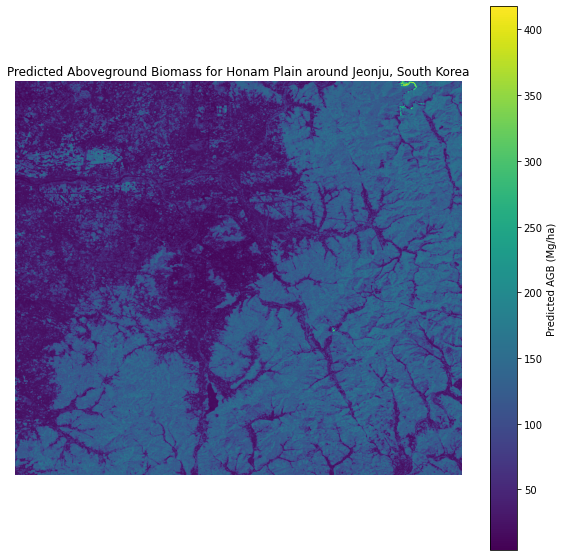

In [ ]:
# Open the predicted AGB raster
with rasterio.open('predicted_agb_sk.tif') as src:
    pred = src.read(1)  # read the first (and only) band

# Plot
plt.figure(figsize=(10, 10))
plt.imshow(pred)  
plt.colorbar(label='Predicted AGB (Mg/ha)')
plt.title('Predicted Aboveground Biomass for Honam Plain around Jeonju, South Korea')
plt.axis('off')  # hide axes for a cleaner map
plt.show()